In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, '/home/aew492/CFE_gradients/code')
import load_tools

#### expected scalings

In [3]:
"""given volume, number density, and representative power spectrum value,
    return the expected precision of the CF estimation: equation from Weinberg OSU"""
def std_grad(V, n, P):
    std = P * (V**(-.5) * (1 + (n*P)**(-1))) * (V**(-1/3))  # last factor is from position dependence across box
    return std

In [47]:
# find corresponding k, and P_G(k), for some input separation r
def get_PkG(r, PkG_fn='/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pkG.dat'):
    kG, PkG = np.loadtxt(PkG_fn).T
    
    k = min(kG, key=lambda x:abs(x-1/r))  # closest k value to 1/r
    P = PkG[np.where(kG==k)][0]
    return k, P

In [48]:
# from the expected_precision notebook, we've decided to use PkG at r=40 as our representative value:
k_rep, P_rep = get_PkG(40)
k_rep, P_rep

(0.02511886432, 76730.64364)

#### precision scalings with boxsize

In [6]:
Ls = [500, 750, 1000, 1500]
n = '1e-4'
m = 1
b = 0.5

In [12]:
amp_arr = np.empty((len(Ls),401,4))

for i, L in enumerate(Ls):
    amp_arr[i] = load_tools.load_suave_amps(f'L{L}_n{n}_z057_patchy_As2x', grad_dim=1, m=m, b=b)

In [13]:
# compress the amplitudes along the realizations to get the spread for each amplitude for each boxsize
amp_stds_L = np.std(amp_arr, axis=1)  # (4,4) array

In [14]:
Ls_cont = np.linspace(min(Ls), max(Ls), 100)
expected_scalings = std_grad(Ls_cont**3, float(n), P_rep)

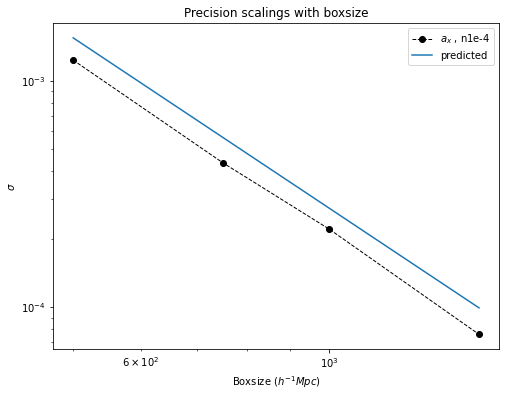

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ls, amp_stds_L[:,1], marker='o', ls='--', lw=1, color='k', label='$a_x$ , n1e-4')
ax.plot(Ls_cont, expected_scalings*10**-1, label='predicted')

ax.set_xlabel('Boxsize ($h^{-1}Mpc$)')
ax.set_ylabel('$\sigma$')
ax.set_title('Precision scalings with boxsize')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

#### precision scalings with number density

In [16]:
L = 750
ns = ['2e-5', '4e-5', '1e-4', '2e-4', '4e-4']
b = 0.5

In [21]:
amp_arr = np.empty((len(ns),401,4))

for i, n in enumerate(ns):
    amp_arr[i] = load_tools.load_suave_amps(f'L{L}_n{n}_z057_patchy_As2x', grad_dim=1, m=1, b=b)

In [23]:
ns_small = ['1e-4', '2e-4']
amp_arr_smallm = np.empty((len(ns_small),401,4))

for i, n in enumerate(ns_small):
    amp_arr_smallm[i] = load_tools.load_suave_amps(f'L{L}_n{n}_z057_patchy_As2x', grad_dim=1, m=0.1)

In [24]:
# compress the amplitudes along the realizations to get the spread for each amplitude for each number density
amp_stds_n = np.std(amp_arr, axis=1)  # (3,4) array
amp_stds_nsm = np.std(amp_arr_smallm, axis=1)

In [25]:
# range of P(k) values to test how much this affects expected values
rs = np.linspace(20,200,10)
PkGs = np.empty((len(rs), 2))

for i,r in enumerate(rs):
    PkGs[i] = get_PkG(r)

In [26]:
ns = [float(n) for n in ns]
ns_sm = [float(n) for n in ns_small]

In [27]:
ns_cont = np.logspace(np.log10(min(ns)), np.log10(max(ns)), 100)

expected_scalings = []
for Pk in PkGs[:,1]:
    expected_scalings.append(std_grad(750**3, ns_cont, Pk))

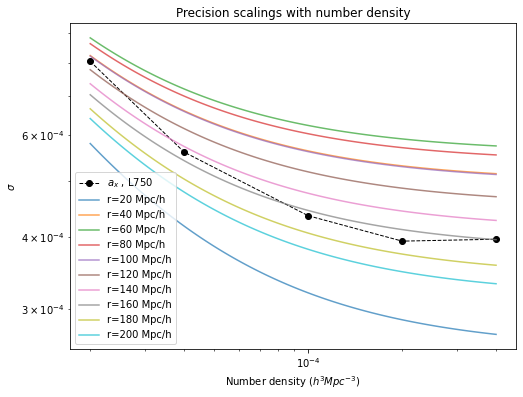

In [28]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(ns, amp_stds_n[:,1], marker='o', ls='--', lw=1, color='k', label='$a_x$ , L750')
# ax.plot(ns_sm, amp_stds_nsm[:,1], marker='o', ls='--', lw=1, color='k', label='$a_x$ small m , L750')
for i,scaling in enumerate(expected_scalings):
    ax.plot(ns_cont, scaling*10**-1, alpha=0.7, label=f'r={rs[i]:.0f} Mpc/h')
# ax.plot(ns_cont, expected_scalings*10**-1.1, label='predicted')

ax.set_xlabel('Number density ($h^3 Mpc^{-3}$)')
ax.set_ylabel('$\sigma$')
ax.set_title('Precision scalings with number density')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [29]:
# locations on input power spectra
kG_in, PkG_in = np.loadtxt(f'/scratch/ksf293/mocks/lognormal/inputs/cat_L750_n2e-4_z057_patchy_As2x_pkG.dat').T

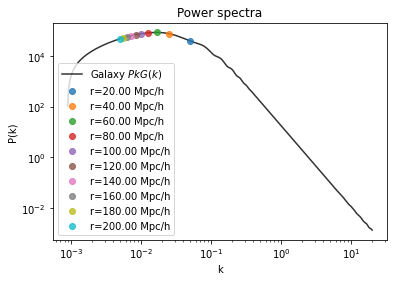

In [30]:
fig, ax = plt.subplots()

ax.plot(kG_in, PkG_in, color='k', alpha=0.8, label='Galaxy $PkG(k)$')

for i, PkG in enumerate(PkGs):
    ax.plot(PkG[0], PkG[1], marker='o', alpha=0.8, ls='None', label=f'r={rs[i]:.2f} Mpc/h')

ax.set_title('Power spectra')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
plt.legend()

### average value of P(k) across length scales

In [76]:
k_min = get_PkG(r=120)[0]
k_max = get_PkG(r=20)[0]

In [77]:
idx = np.arange(np.where(kG_in==k_min)[0], np.where(kG_in==k_max)[0])

In [78]:
k_range = kG_in[idx]
P_range = PkG_in[idx]

In [79]:
P_avg = 1/(k_max-k_min) * np.trapz(P_range, k_range)

In [80]:
P_avg

64934.876654695996